## Data Import and Prep

In [78]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.model_selection import StratifiedShuffleSplit


In [58]:
def plot_confusion_matrix(cm):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    
def plot_roc(y, pred, title):
    fpr, tpr, _ = metrics.roc_curve(pred, y)
    auc = metrics.roc_auc_score(pred, y)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

In [6]:
df = pd.read_csv('normalizedbloodOApatientsdata.csv', header=None)
df = df.T
df = df.drop(df.index[0]).rename(columns=df.iloc[0])

df = df.dropna(axis='columns')
df_gene = df[[x for x in df.columns if "ILMN" in x ]]
df_gene = df_gene.astype('float', copy=False)
df_cat = df[[x for x in df.columns if "ILMN" not in x ]]

df_ch1 = df_cat['!Sample_characteristics_ch1']
colnames = []
for col in range(df_ch1.shape[1]):
    colnames.append(df_cat['!Sample_characteristics_ch1'].iloc[:,col].str.split(':').str[0].unique()[0]) 
    df_ch1.iloc[:,col] = df_ch1.iloc[:,col].str.split(':').str[1]
    
df_ch1.columns = colnames    
df_ch1 = df_ch1.iloc[:, 0:5]

df = pd.concat([df_ch1, df_gene], axis=1)
df['age (yrs)'] = df['age (yrs)'].astype('int', copy=False)

C:\Users\steve\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\steve\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_s

In [7]:
gender = pd.get_dummies(df['gender'])
disease = pd.get_dummies(df['disease state'])
# Drop column B as it is now encoded
df = df.drop(['gender','disease state'],axis = 1)
# Join the encoded df
df = df.join(gender)
df = df.join(disease)
df.columns = df.columns.str.strip()

## Feature Selection using Mutual Info

In [8]:
# Number of features to retain
k = 20

# create the SelectKBest with the mutual info strategy.
selection = SelectKBest(mutual_info_classif, k=k).fit(df_gene, df['case'])
features = df_gene.columns[selection.get_support()]
features = ['Male','age (yrs)']+features.tolist()

## Model Building - K-Fold Cross Validation

### Logistic Regression with L1 Penalty

In [11]:
lasso_log_reg = LogisticRegression(penalty='l1',solver='liblinear')
llr_scores = cross_val_score(lasso_log_reg,df[features], df['case'], cv=3)
llr_mean_acc = np.mean(llr_scores)
print("Average Accuracy: {}".format(llr_mean_acc))

Average Accuracy: 0.8925377736663583


In [12]:
llr_pred = cross_val_predict(LogisticRegression(penalty='l1',solver='liblinear'),  df[features], df['case'], cv=3)

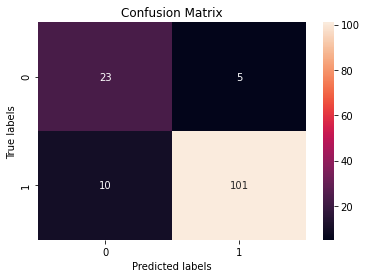

In [19]:
plot_confusion_matrix(confusion_matrix(llr_pred, df['case']))

In [21]:
# Ratio of correctly predicted positive instances out of all positive instances
llr_prec = precision_score(llr_pred, df['case'])

# Ratio of correctly predicted positive instances to the all observations in actual class
llr_rec = recall_score(llr_pred, df['case'])
print("Precision Score: {}\nRecall Score: {}".format(llr_prec,llr_rec))

Precision Score: 0.9528301886792453
Recall Score: 0.9099099099099099


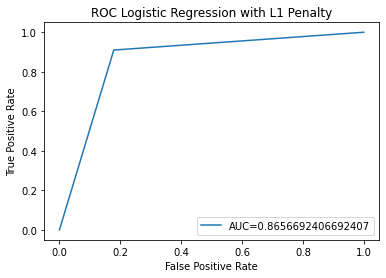

In [59]:
plot_roc(df['case'], llr_pred, "ROC Logistic Regression with L1 Penalty")

### Random Forest

In [39]:
acc = []
leaves  =[]
for max_leaf_node in range(2,100):
    random_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=max_leaf_node, n_jobs=-1)
    rf_scores = cross_val_score(random_forest,df[features], df['case'], cv=3)
    rf_mean_acc = np.mean(rf_scores)
    acc.append(rf_mean_acc)
    leaves.append(max_leaf_node)

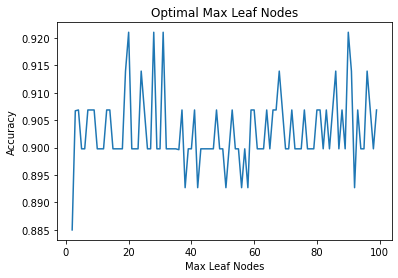

In [40]:
plt.plot(leaves, acc)
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Accuracy")
plt.title("Optimal Max Leaf Nodes")
plt.show()

In [49]:
random_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=20, n_jobs=-1)
rf_scores = cross_val_score(random_forest,df[features], df['case'], cv=3)
rf_mean_acc = np.mean(rf_scores)
print("Average Accuracy: {}".format(rf_mean_acc))

Average Accuracy: 0.913968547641073


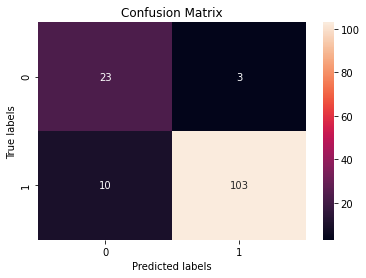

In [50]:
rf_pred = cross_val_predict(random_forest,  df[features], df['case'], cv=3)
plot_confusion_matrix(confusion_matrix(rf_pred, df['case']))

In [51]:
# Ratio of correctly predicted positive instances out of all positive instances
rf_prec = precision_score(rf_pred, df['case'])

# Ratio of correctly predicted positive instances to the all observations in actual class
rf_rec = recall_score(rf_pred, df['case'])
print("Precision Score: {}\nRecall Score: {}".format(rf_prec,rf_rec))

Precision Score: 0.9716981132075472
Recall Score: 0.911504424778761


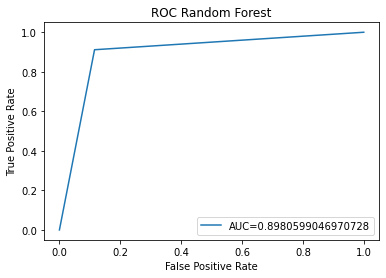

In [60]:
plot_roc(df['case'], rf_pred, "ROC Random Forest")

### SVM

In [65]:
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, df[features], df['case'], cv=3)
svc_mean_acc = np.mean(svc_scores)
print("Average Accuracy: {}".format(svc_mean_acc))

Average Accuracy: 0.7625655257477645


In [66]:
svc_scores

array([0.76595745, 0.76086957, 0.76086957])

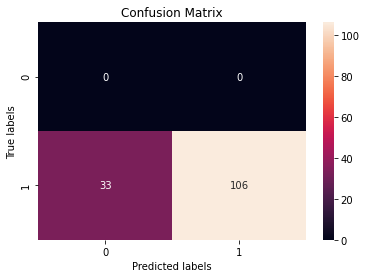

In [67]:
svc_pred = cross_val_predict(svc_clf,  df[features], df['case'], cv=3)
plot_confusion_matrix(confusion_matrix(svc_pred, df['case']))

In [68]:
# Ratio of correctly predicted positive instances out of all positive instances
svc_prec = precision_score(svc_pred, df['case'])

# Ratio of correctly predicted positive instances to the all observations in actual class
svc_rec = recall_score(svc_pred, df['case'])
print("Precision Score: {}\nRecall Score: {}".format(svc_prec,svc_rec))

Precision Score: 1.0
Recall Score: 0.762589928057554


## Model Building - Voting Classifier

### Train Test Split

In [73]:
df = df.reset_index()

In [75]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_index in split.split(df, df['case']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [86]:
train_x, train_y = strat_train_set[features], strat_train_set['case']
test_x, test_y = strat_test_set[features], strat_test_set['case']

In [93]:
llr_clf = LogisticRegression(penalty='l1',solver='liblinear') 
svc_clf = SVC()
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=20, n_jobs=-1)
voting_clf_hard = VotingClassifier(estimators=[('llr', llr_clf),('rf',rf_clf), ('svc', svc_clf)], voting='hard')
voting_clf_soft = VotingClassifier(estimators=[('llr', llr_clf),('rf',rf_clf), ('svc', SVC(probability=True))], voting='soft')

In [94]:
for clf in (llr_clf, svc_clf, rf_clf, voting_clf_hard, voting_clf_soft):
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    print(clf.__class__.__name__, accuracy_score(test_y, y_pred))

LogisticRegression 0.9642857142857143
SVC 0.7678571428571429
RandomForestClassifier 0.9642857142857143
VotingClassifier 0.9642857142857143
VotingClassifier 0.9642857142857143


#### In Sample Eval

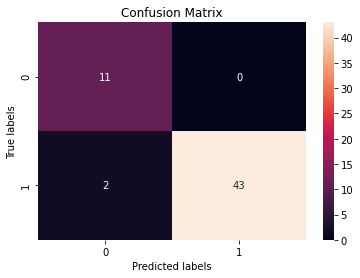

In [95]:
# Out of Sample Confusion Matrix
voting_clf_hard.fit(train_x, train_y)
y_pred = voting_clf_hard.predict(test_x)
plot_confusion_matrix(confusion_matrix(y_pred, test_y))

In [96]:
# Ratio of correctly predicted positive instances out of all positive instances
voting_prec = precision_score(y_pred, test_y)

# Ratio of correctly predicted positive instances to the all observations in actual class
voting_rec = recall_score(y_pred, test_y)
print("Precision Score: {}\nRecall Score: {}".format(voting_prec,voting_rec))

Precision Score: 1.0
Recall Score: 0.9555555555555556


#### Out of Sample Eval

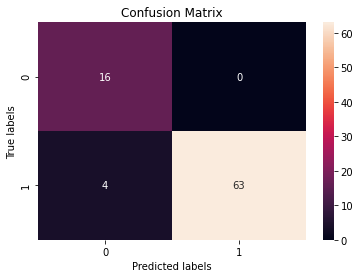

In [98]:
# In Sample Matrix
y_train_pred = voting_clf_hard.predict(train_x)
plot_confusion_matrix(confusion_matrix(y_train_pred, train_y))

In [101]:
# Ratio of correctly predicted positive instances out of all positive instances
voting_prec_train = precision_score(y_train_pred, train_y)

# Ratio of correctly predicted positive instances to the all observations in actual class
voting_rec_train = recall_score(y_pred, test_y)
print("Precision Score: {}\nRecall Score: {}".format(voting_prec_train,voting_rec_train))

Precision Score: 1.0
Recall Score: 0.9555555555555556


### K Fold Cross Val

In [97]:
for clf in (llr_clf, svc_clf, rf_clf, voting_clf_hard, voting_clf_soft):
    
    scores = cross_val_score(clf, df[features], df['case'], cv=3)
    mean_acc = np.mean(scores)
    print("{} Average Accuracy: {}".format(clf.__class__.__name__, mean_acc))

LogisticRegression Average Accuracy: 0.8925377736663583
SVC Average Accuracy: 0.7625655257477645
RandomForestClassifier Average Accuracy: 0.8997841504779526
VotingClassifier Average Accuracy: 0.8781991982732039
VotingClassifier Average Accuracy: 0.8925377736663583
